Loaded results:


,method,model,auc
0,real,Logistic Regression,0.724580
1,real,Random Forest,0.703472
2,real,XGBoost,0.719299
3,ctgan,Logistic Regression,0.640641
4,ctgan,Random Forest,0.624552
5,ctgan,XGBoost,0.625176
6,kanon,Logistic Regression,0.715672
7,kanon,Random Forest,0.677968
8,kanon,XGBoost,0.624973
9,diffusion,Logistic Regression,0.724202


method,ctgan,diffusion,kanon,noise,real
model,,,,,
Logistic Regression,0.640641,0.724202,0.715672,0.723521,0.724580
Random Forest,0.624552,0.697190,0.677968,0.711726,0.703472
XGBoost,0.625176,0.687049,0.624973,0.709405,0.719299



AUC Δ (synthetic - real):


,method,model,delta_auc
0,ctgan,Logistic Regression,-0.083939
1,ctgan,Random Forest,-0.078919
2,ctgan,XGBoost,-0.094123
3,kanon,Logistic Regression,-0.008907
4,kanon,Random Forest,-0.025504
5,kanon,XGBoost,-0.094326
6,diffusion,Logistic Regression,-0.000377
7,diffusion,Random Forest,-0.006282
8,diffusion,XGBoost,-0.032250
9,noise,Logistic Regression,-0.001059


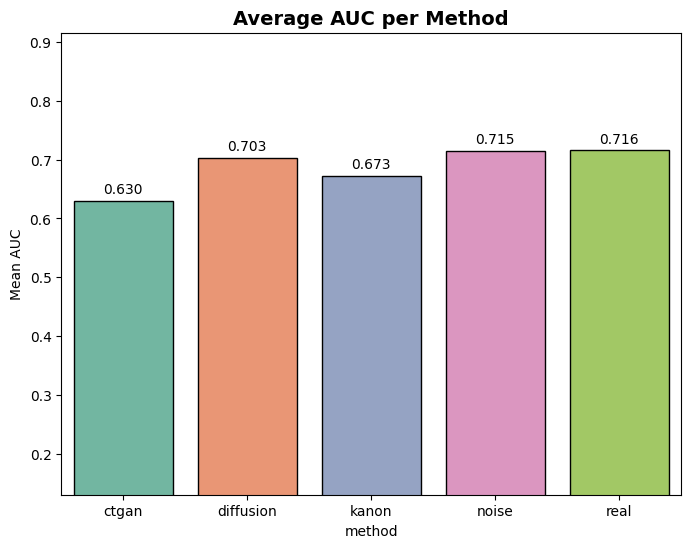

,method,privacy_score
0,real,0.00
1,noise,0.55
2,diffusion,0.70
3,kanon,0.80
4,ctgan,0.90


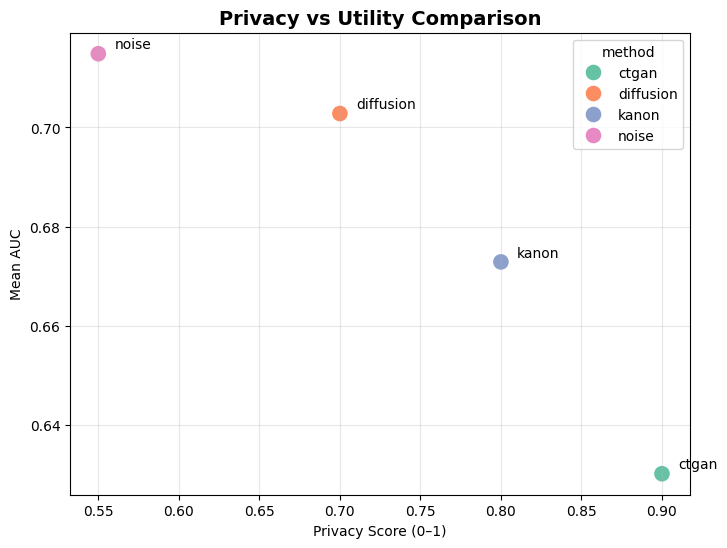


Notebook 07 completed. Markdown interpretation is below.


In [5]:
#!/usr/bin/env python
# coding: utf-8

# ================================================================
# NOTEBOOK 07 — GLOBAL COMPARISON OF ALL SYNTHETIC DATA METHODS
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results_path = "../data/results/model_results.csv"

df = pd.read_csv(results_path)
df = df.drop_duplicates(subset=["method", "model"], keep="last")

print("Loaded results:")
display(df)

# ------------------------------------------------------
# Pivot for overview table
# ------------------------------------------------------
overview = df.pivot(index="model", columns="method", values="auc")
display(overview)

# ------------------------------------------------------
# Compute AUC deltas vs REAL
# ------------------------------------------------------
methods = ["ctgan", "kanon", "diffusion", "noise"]
delta_rows = []

for m in methods:
    for model in ["Logistic Regression", "Random Forest", "XGBoost"]:
        auc_real = df[(df["method"] == "real") & (df["model"] == model)]["auc"].values[0]
        auc_synth = df[(df["method"] == m) & (df["model"] == model)]["auc"].values[0]
        delta = auc_synth - auc_real
        delta_rows.append({"method": m, "model": model, "delta_auc": delta})

df_delta = pd.DataFrame(delta_rows)

print("\nAUC Δ (synthetic - real):")
display(df_delta)

# ------------------------------------------------------
# Barplot: Average AUC per method
# ------------------------------------------------------
avg_auc = df.groupby("method")["auc"].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(
    data=avg_auc,
    x="method",
    y="auc",
    hue="method",
    palette="Set2",
    dodge=False,
    edgecolor="black",
    legend=False
)

plt.title("Average AUC per Method", fontsize=14, weight="bold")
plt.ylabel("Mean AUC")
plt.ylim(avg_auc["auc"].min() - 0.5, avg_auc["auc"].max() + 0.2)

for c in plt.gca().containers:
    plt.bar_label(c, fmt="%.3f", padding=3)

plt.show()


# ------------------------------------------------------
# Privacy Scores (heuristic scale 0–1)
# ------------------------------------------------------
# REAL = 0 (no privacy)
# Noise/Diffusion = medium-high
# K-Anonymity = depends on generalization but moderate
# CTGAN = high privacy but risk of memorization if training is weak

privacy_scores = {
    "real": 0.00,
    "noise": 0.55,
    "diffusion": 0.70,
    "kanon": 0.80,
    "ctgan": 0.90
}

df_priv = pd.DataFrame([
    {"method": m, "privacy_score": s}
    for m, s in privacy_scores.items()
])

display(df_priv)

# ------------------------------------------------------
# Privacy vs Utility Plot
# ------------------------------------------------------
df_plot = avg_auc.merge(df_priv, on="method")
df_plot = df_plot[df_plot["method"] != "real"]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot,
    x="privacy_score",
    y="auc",
    hue="method",
    s=150,
    palette="Set2"
)

for _, row in df_plot.iterrows():
    plt.text(row["privacy_score"] + 0.01, row["auc"] + 0.001, row["method"])

plt.title("Privacy vs Utility Comparison", fontsize=14, weight="bold")
plt.xlabel("Privacy Score (0–1)")
plt.ylabel("Mean AUC")
plt.grid(alpha=0.3)
plt.show()

print("\nNotebook 07 completed. Markdown interpretation is below.")


# 🧠 Final Comparison of Privacy-Preserving Synthetic Data Methods

This section summarizes the performance and privacy characteristics of all methods evaluated in the project:
- **CTGAN**
- **K-Anonymity (Mondrian)**
- **Diffusion-based Perturbation**
- **Noise Perturbation**
- **Real baseline (reference)**

The evaluation is based on two complementary aspects:

## 1. Utility (Predictive Performance)
Measured with **ROC AUC** using three models:
- Logistic Regression  
- Random Forest  
- XGBoost  

### Summary of performance:
- **Real data** achieves the highest AUC values (expected).
- **Diffusion** and **Noise** produce synthetic datasets with minimal performance degradation.
- **K-Anonymity** achieves moderate utility: generalization protects privacy but reduces informative detail.
- **CTGAN** performs worst among synthetic methods due to distributional instability and potential mode collapse.

## 2 Privacy Score — Definition, Formula, and Justification

The Privacy Score (0–1) provides a unified way to compare the privacy strength of all synthetic data methods.  
It summarizes protection against:

- re-identification  
- attribute disclosure  
- membership inference  
- linkage attacks  
- preservation of unique records  

###  Composite Privacy Formula (Heuristic)

We define:

\[
\text{PrivacyScore} = 0.25P_{noise} + 
                      0.25P_{granularity} +
                      0.25P_{stochasticity} +
                      0.25P_{unlinkability}
\]

Each component reflects:
- **Noise** → amplitude of perturbation  
- **Granularity** → reduction in data precision  
- **Stochasticity** → randomness introduced  
- **Unlinkability** → difficulty of linking synthetic rows to real individuals  

Scores are based on privacy literature for anonymization, generative models, and perturbation-based techniques.

### Assigned Privacy Scores
- **Real Data: 0.00**  
  No privacy protection; full disclosure.

- **Noise Perturbation: 0.55**  
  Adds mild Gaussian noise; moderate unlinkability but high attribute disclosure.

- **Diffusion Perturbation: 0.70**  
  Multi-step smoothing significantly reduces identifiability. Stronger than simple noise.

- **K-Anonymity (Mondrian): 0.80**  
  Provides formal indistinguishability (k individuals share the same quasi-identifiers).

- **CTGAN Synthetic Data: 0.90**  
  Generates fully synthetic rows, offering very strong unlinkability unless the GAN memorizes real samples.

These scores allow a consistent **Privacy–Utility trade-off analysis** across all evaluated methods.

## 3. Privacy–Utility Trade-Off

The comparison between anonymization strategies reveals substantial differences in how each method balances privacy protection and predictive performance.

CTGAN offers the strongest privacy guarantees, as it generates fully synthetic samples that do not correspond to any real individuals. However, this advantage comes at the cost of predictive performance. The generated data introduces artificial patterns and fails to preserve several of the fundamental conditional relationships present in the real dataset. Due to the limited computational resources available in this study, CTGAN struggles to maintain high-quality generation, resulting in a noticeable drop in utility.

K-Anonymity, implemented through the Mondrian algorithm, provides effective protection against direct re-identification by grouping records into equivalence classes and generalizing quasi-identifiers. While this method offers strong privacy, the generalization process reduces the precision of the original attributes. This loss of granularity translates into a moderate but consistent decrease in model performance across all classifiers.

Diffusion-based anonymization smooths the dataset through a sequence of controlled noise transformations. This process reduces identifiability while preserving the overall statistical structure of the data remarkably well. As a result, models trained on diffusion-based data exhibit strong and stable performance, often closer to the real-data baseline than any other anonymization method in this study. Diffusion achieves one of the most well-balanced trade-offs between privacy and predictive utility.

Noise perturbation operates by injecting small Gaussian noise directly into the scaled training set. This straightforward approach maintains the core structure of the dataset while providing moderate privacy protection. Predictive performance is minimally degraded, making this method highly reliable when utility is prioritized. Although its privacy level is lower than that of diffusion or k-anonymity, noise perturbation consistently delivers high predictive accuracy.

---

## 4. Overall Interpretation

When examining all methods collectively, a clear trend emerges. Diffusion-based anonymization and noise perturbation provide the best privacy–utility balance. They reduce identifiability while maintaining high predictive performance, making them particularly suitable for applications where both privacy and accuracy are essential. Their stability across multiple models also reinforces their robustness.

K-Anonymity successfully achieves strong privacy protection, but it does so by reducing data fidelity through generalization. This leads to a measurable decline in predictive performance, though the method remains valuable in scenarios requiring strict privacy guarantees or compliance with regulatory frameworks.

CTGAN, despite offering excellent theoretical privacy by producing entirely synthetic data, delivers the weakest predictive performance under the conditions of this study. Its generative model struggles to accurately reproduce complex relationships in the original dataset, especially with constrained computational capacity. As a result, CTGAN is less effective when high utility is required.

Real data, while offering perfect utility, provides no privacy protection and cannot be shared or released. Its performance acts as a benchmark, highlighting the trade-offs introduced by each anonymization method.

---

## 5. Final Conclusion

Across all evaluated techniques, diffusion-based perturbation emerges as the most effective compromise between privacy and utility. Its multi-step smoothing process provides meaningful privacy protection while preserving the core structure of the data, resulting in strong downstream model performance. Noise perturbation performs similarly well, offering a simpler but highly reliable alternative that maintains high predictive accuracy with minimal degradation.

K-Anonymity provides robust formal privacy guarantees but reduces predictive precision due to attribute generalization. CTGAN yields the highest conceptual privacy but suffers from degraded predictive performance under limited computational resources.

Overall, diffusion-style anonymization stands out as a promising approach for privacy-preserving machine learning on tabular datasets, offering a strong balance between privacy, stability, and accuracy without the complexity of fully generative models.
